In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [2]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 4:4+self.out_channels]
        return img


In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 512
    tile_size = 512
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 4
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 20  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_dice_loss"
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(13, 6, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(13, 6, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image, fragment_i, split_i):
    # topography = cv2.imread(f"{CFG.dataset_path}/topography_{fragment_i}_{split_i}.png",-1)
    # topography = topography.astype("uint16")*1057
    # pad0 = (CFG.tile_size - topography.shape[0] % CFG.tile_size)
    # pad1 = (CFG.tile_size - topography.shape[1] % CFG.tile_size)
    # topography = np.pad(topography, [(0, pad0), (0, pad1)], constant_values=0)
    # topography = np.expand_dims(topography, axis=2)
    # image=np.concatenate([image,topography], axis=2)
    return image



len(train_images) = 2718
train_images[0].shape = (512, 512, 13)
train_labels[0].shape = (512, 512, 1)
train_masks[0].shape = (512, 512, 1)

len(valid_images) = 775
valid_images[0].shape = (512, 512, 13)
valid_labels[0].shape = (512, 512, 1)



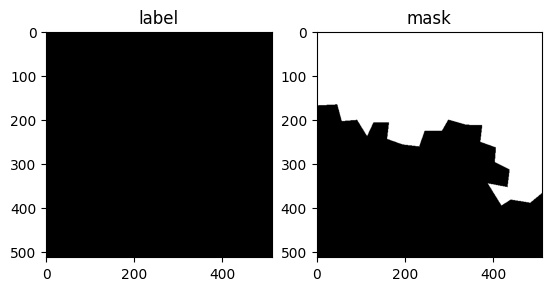

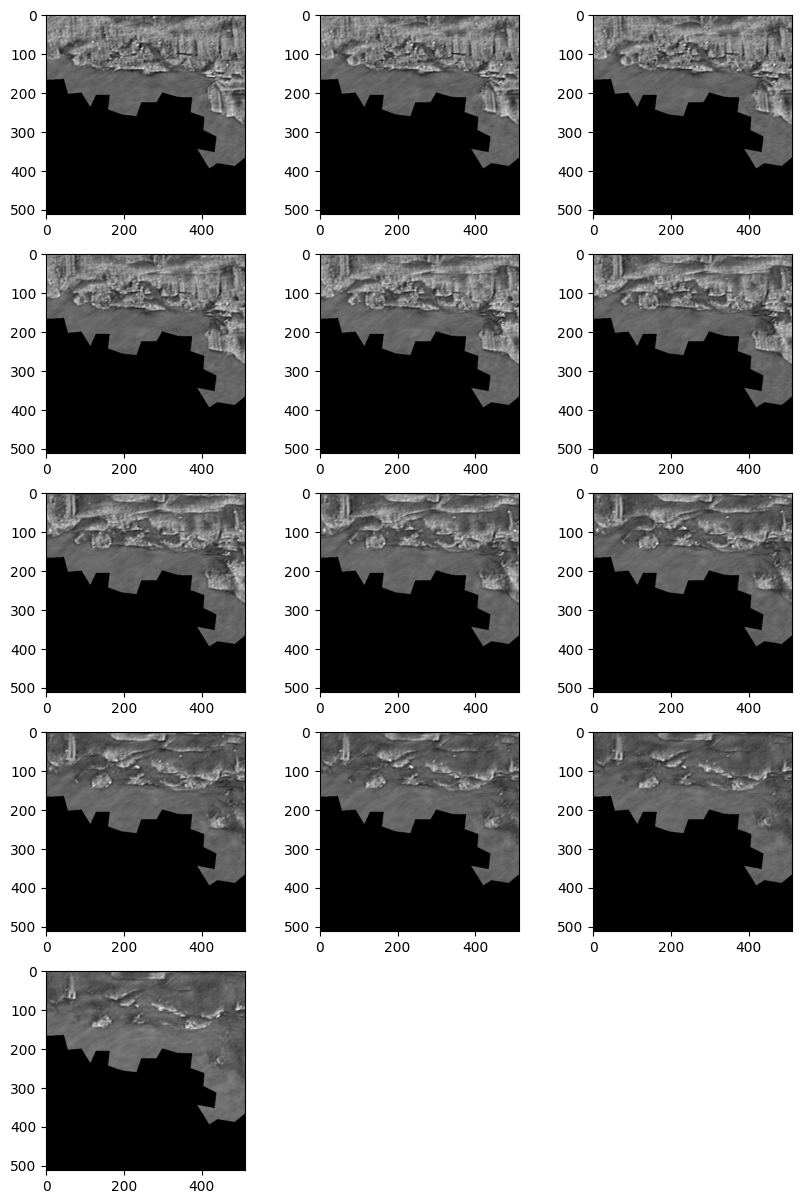

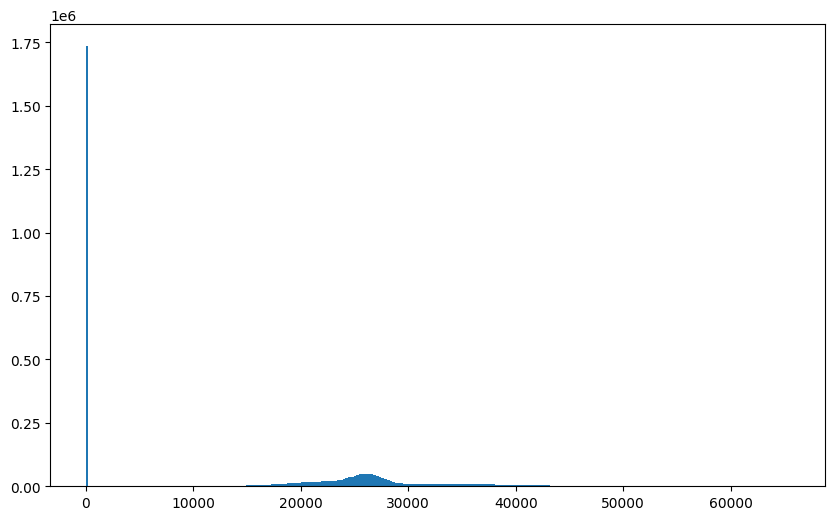

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


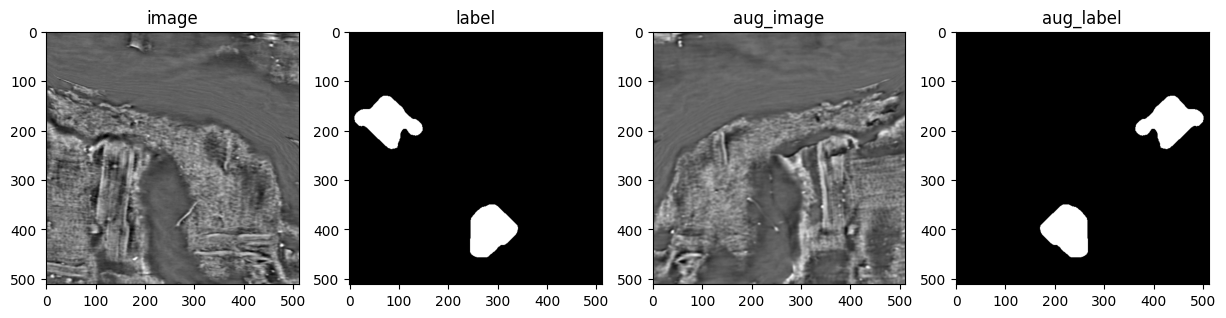

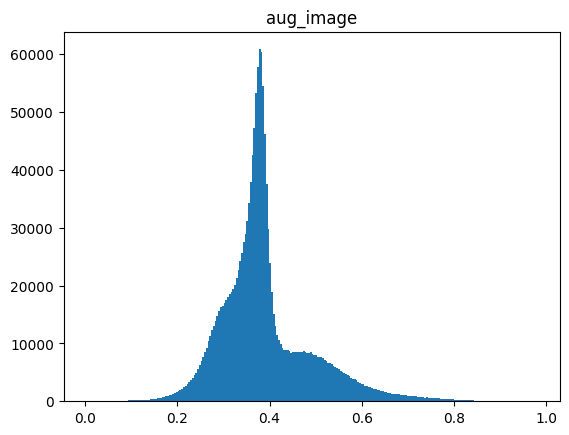

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0


100%|███████████████████████████████████████████| 13/13 [00:14<00:00,  1.12s/it]


fbeta: 0.2693
Epoch 1 - avg_train_loss: 1.5616  avg_val_loss: 1.3752  avgScore: 0.2693  time: 99s
Epoch 1 - Save Best Loss: 1.3752  Best Score: 0.2693 Model



100%|███████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


fbeta: 0.3260
Epoch 2 - avg_train_loss: 1.3730  avg_val_loss: 1.2708  avgScore: 0.3260  time: 64s
Epoch 2 - Save Best Loss: 1.2708  Best Score: 0.3260 Model



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  1.94it/s]


fbeta: 0.4194
Epoch 3 - avg_train_loss: 1.1599  avg_val_loss: 1.1172  avgScore: 0.4194  time: 61s
Epoch 3 - Save Best Loss: 1.1172  Best Score: 0.4194 Model



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.00it/s]


fbeta: 0.2919
Epoch 4 - avg_train_loss: 0.9877  avg_val_loss: 1.1059  avgScore: 0.2919  time: 58s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.01it/s]


fbeta: 0.3941
Epoch 5 - avg_train_loss: 0.8836  avg_val_loss: 0.9917  avgScore: 0.3941  time: 59s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.02it/s]


fbeta: 0.3747
Epoch 6 - avg_train_loss: 0.8168  avg_val_loss: 1.0374  avgScore: 0.3747  time: 58s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.04it/s]


fbeta: 0.4649
Epoch 7 - avg_train_loss: 0.7654  avg_val_loss: 0.9045  avgScore: 0.4649  time: 61s
Epoch 7 - Save Best Loss: 0.9045  Best Score: 0.4649 Model



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.02it/s]


fbeta: 0.4565
Epoch 8 - avg_train_loss: 0.7296  avg_val_loss: 0.8921  avgScore: 0.4565  time: 58s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.05it/s]


fbeta: 0.4660
Epoch 9 - avg_train_loss: 0.6846  avg_val_loss: 0.8878  avgScore: 0.4660  time: 58s
Epoch 9 - Save Best Loss: 0.8878  Best Score: 0.4660 Model



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.06it/s]


fbeta: 0.5470
Epoch 10 - avg_train_loss: 0.6478  avg_val_loss: 0.8757  avgScore: 0.5470  time: 56s
Epoch 10 - Save Best Loss: 0.8757  Best Score: 0.5470 Model



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.09it/s]


fbeta: 0.4930
Epoch 11 - avg_train_loss: 0.6146  avg_val_loss: 0.8508  avgScore: 0.4930  time: 56s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.04it/s]


fbeta: 0.4397
Epoch 12 - avg_train_loss: 0.5855  avg_val_loss: 0.9116  avgScore: 0.4397  time: 57s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.13it/s]


fbeta: 0.5017
Epoch 13 - avg_train_loss: 0.5574  avg_val_loss: 0.8481  avgScore: 0.5017  time: 56s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.12it/s]


fbeta: 0.4833
Epoch 14 - avg_train_loss: 0.5357  avg_val_loss: 0.8607  avgScore: 0.4833  time: 57s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.11it/s]


fbeta: 0.4454
Epoch 15 - avg_train_loss: 0.5206  avg_val_loss: 0.9114  avgScore: 0.4454  time: 57s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.07it/s]


fbeta: 0.4904
Epoch 16 - avg_train_loss: 0.5007  avg_val_loss: 0.8697  avgScore: 0.4904  time: 57s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.09it/s]


fbeta: 0.5231
Epoch 17 - avg_train_loss: 0.4825  avg_val_loss: 0.8462  avgScore: 0.5231  time: 56s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.09it/s]


fbeta: 0.5213
Epoch 18 - avg_train_loss: 0.4700  avg_val_loss: 0.8430  avgScore: 0.5213  time: 56s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.06it/s]


fbeta: 0.5330
Epoch 19 - avg_train_loss: 0.4503  avg_val_loss: 0.8483  avgScore: 0.5330  time: 57s



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.06it/s]


fbeta: 0.5103
Epoch 20 - avg_train_loss: 0.4484  avg_val_loss: 0.8627  avgScore: 0.5103  time: 57s

fold: 1


100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.58it/s]


fbeta: 0.1727
Epoch 1 - avg_train_loss: 1.6856  avg_val_loss: 1.5300  avgScore: 0.1727  time: 59s
Epoch 1 - Save Best Loss: 1.5300  Best Score: 0.1727 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.77it/s]


fbeta: 0.2221
Epoch 2 - avg_train_loss: 1.4736  avg_val_loss: 1.3973  avgScore: 0.2221  time: 59s
Epoch 2 - Save Best Loss: 1.3973  Best Score: 0.2221 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.82it/s]


fbeta: 0.4291
Epoch 3 - avg_train_loss: 1.2207  avg_val_loss: 1.0622  avgScore: 0.4291  time: 58s
Epoch 3 - Save Best Loss: 1.0622  Best Score: 0.4291 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.74it/s]


fbeta: 0.4615
Epoch 4 - avg_train_loss: 1.0181  avg_val_loss: 0.9552  avgScore: 0.4615  time: 58s
Epoch 4 - Save Best Loss: 0.9552  Best Score: 0.4615 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.82it/s]


fbeta: 0.5633
Epoch 5 - avg_train_loss: 0.9089  avg_val_loss: 0.8902  avgScore: 0.5633  time: 58s
Epoch 5 - Save Best Loss: 0.8902  Best Score: 0.5633 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.71it/s]


fbeta: 0.5946
Epoch 6 - avg_train_loss: 0.8393  avg_val_loss: 0.8262  avgScore: 0.5946  time: 58s
Epoch 6 - Save Best Loss: 0.8262  Best Score: 0.5946 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.76it/s]


fbeta: 0.5054
Epoch 7 - avg_train_loss: 0.7870  avg_val_loss: 0.8449  avgScore: 0.5054  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.80it/s]


fbeta: 0.5249
Epoch 8 - avg_train_loss: 0.7282  avg_val_loss: 0.8607  avgScore: 0.5249  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.78it/s]


fbeta: 0.4586
Epoch 9 - avg_train_loss: 0.7030  avg_val_loss: 0.8578  avgScore: 0.4586  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.80it/s]


fbeta: 0.4611
Epoch 10 - avg_train_loss: 0.6572  avg_val_loss: 0.8302  avgScore: 0.4611  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:05<00:00,  1.84it/s]


fbeta: 0.5148
Epoch 11 - avg_train_loss: 0.6300  avg_val_loss: 0.7866  avgScore: 0.5148  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.76it/s]


fbeta: 0.5648
Epoch 12 - avg_train_loss: 0.6022  avg_val_loss: 0.7874  avgScore: 0.5648  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.72it/s]


fbeta: 0.5609
Epoch 13 - avg_train_loss: 0.5758  avg_val_loss: 0.7718  avgScore: 0.5609  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.82it/s]


fbeta: 0.5237
Epoch 14 - avg_train_loss: 0.5595  avg_val_loss: 0.8212  avgScore: 0.5237  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.81it/s]


fbeta: 0.5366
Epoch 15 - avg_train_loss: 0.5417  avg_val_loss: 0.8124  avgScore: 0.5366  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:05<00:00,  1.86it/s]


fbeta: 0.5597
Epoch 16 - avg_train_loss: 0.5110  avg_val_loss: 0.8268  avgScore: 0.5597  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.80it/s]


fbeta: 0.5396
Epoch 17 - avg_train_loss: 0.4894  avg_val_loss: 0.7717  avgScore: 0.5396  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.79it/s]


fbeta: 0.5365
Epoch 18 - avg_train_loss: 0.4819  avg_val_loss: 0.7965  avgScore: 0.5365  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.82it/s]


fbeta: 0.5498
Epoch 19 - avg_train_loss: 0.4690  avg_val_loss: 0.7947  avgScore: 0.5498  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.78it/s]


fbeta: 0.5608
Epoch 20 - avg_train_loss: 0.4660  avg_val_loss: 0.7847  avgScore: 0.5608  time: 58s

fold: 2


100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.66it/s]


fbeta: 0.2900
Epoch 1 - avg_train_loss: 1.2183  avg_val_loss: 1.2592  avgScore: 0.2900  time: 59s
Epoch 1 - Save Best Loss: 1.2592  Best Score: 0.2900 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.74it/s]


fbeta: 0.3725
Epoch 2 - avg_train_loss: 1.1226  avg_val_loss: 1.1723  avgScore: 0.3725  time: 59s
Epoch 2 - Save Best Loss: 1.1723  Best Score: 0.3725 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.76it/s]


fbeta: 0.4508
Epoch 3 - avg_train_loss: 1.0035  avg_val_loss: 1.0466  avgScore: 0.4508  time: 58s
Epoch 3 - Save Best Loss: 1.0466  Best Score: 0.4508 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.81it/s]


fbeta: 0.4794
Epoch 4 - avg_train_loss: 0.8683  avg_val_loss: 1.0178  avgScore: 0.4794  time: 58s
Epoch 4 - Save Best Loss: 1.0178  Best Score: 0.4794 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.82it/s]


fbeta: 0.5353
Epoch 5 - avg_train_loss: 0.8027  avg_val_loss: 0.9585  avgScore: 0.5353  time: 58s
Epoch 5 - Save Best Loss: 0.9585  Best Score: 0.5353 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.78it/s]


fbeta: 0.5183
Epoch 6 - avg_train_loss: 0.7497  avg_val_loss: 0.9723  avgScore: 0.5183  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.78it/s]


fbeta: 0.5428
Epoch 7 - avg_train_loss: 0.7124  avg_val_loss: 0.9836  avgScore: 0.5428  time: 58s
Epoch 7 - Save Best Loss: 0.9836  Best Score: 0.5428 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.83it/s]


fbeta: 0.5542
Epoch 8 - avg_train_loss: 0.6731  avg_val_loss: 0.9429  avgScore: 0.5542  time: 58s
Epoch 8 - Save Best Loss: 0.9429  Best Score: 0.5542 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.81it/s]


fbeta: 0.5680
Epoch 9 - avg_train_loss: 0.6425  avg_val_loss: 0.9722  avgScore: 0.5680  time: 58s
Epoch 9 - Save Best Loss: 0.9722  Best Score: 0.5680 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.78it/s]


fbeta: 0.5724
Epoch 10 - avg_train_loss: 0.6073  avg_val_loss: 0.9526  avgScore: 0.5724  time: 59s
Epoch 10 - Save Best Loss: 0.9526  Best Score: 0.5724 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.74it/s]


fbeta: 0.5671
Epoch 11 - avg_train_loss: 0.5839  avg_val_loss: 0.9269  avgScore: 0.5671  time: 59s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.81it/s]


fbeta: 0.5424
Epoch 12 - avg_train_loss: 0.5571  avg_val_loss: 1.1307  avgScore: 0.5424  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.80it/s]


fbeta: 0.5641
Epoch 13 - avg_train_loss: 0.5405  avg_val_loss: 1.0548  avgScore: 0.5641  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.77it/s]


fbeta: 0.5852
Epoch 14 - avg_train_loss: 0.5226  avg_val_loss: 1.0339  avgScore: 0.5852  time: 58s
Epoch 14 - Save Best Loss: 1.0339  Best Score: 0.5852 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.78it/s]


fbeta: 0.5751
Epoch 15 - avg_train_loss: 0.5003  avg_val_loss: 1.0086  avgScore: 0.5751  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.78it/s]


fbeta: 0.5659
Epoch 16 - avg_train_loss: 0.4729  avg_val_loss: 0.9812  avgScore: 0.5659  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.75it/s]


fbeta: 0.5682
Epoch 17 - avg_train_loss: 0.4639  avg_val_loss: 1.0061  avgScore: 0.5682  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.81it/s]


fbeta: 0.5809
Epoch 18 - avg_train_loss: 0.4576  avg_val_loss: 1.0227  avgScore: 0.5809  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.81it/s]


fbeta: 0.5820
Epoch 19 - avg_train_loss: 0.4403  avg_val_loss: 0.9920  avgScore: 0.5820  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.78it/s]


fbeta: 0.5769
Epoch 20 - avg_train_loss: 0.4334  avg_val_loss: 0.9901  avgScore: 0.5769  time: 59s

fold: 3


100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.63it/s]


fbeta: 0.2313
Epoch 1 - avg_train_loss: 1.5659  avg_val_loss: 1.4816  avgScore: 0.2313  time: 59s
Epoch 1 - Save Best Loss: 1.4816  Best Score: 0.2313 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.72it/s]


fbeta: 0.2927
Epoch 2 - avg_train_loss: 1.3560  avg_val_loss: 1.3453  avgScore: 0.2927  time: 58s
Epoch 2 - Save Best Loss: 1.3453  Best Score: 0.2927 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.74it/s]


fbeta: 0.4943
Epoch 3 - avg_train_loss: 1.1428  avg_val_loss: 1.0968  avgScore: 0.4943  time: 59s
Epoch 3 - Save Best Loss: 1.0968  Best Score: 0.4943 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.80it/s]


fbeta: 0.5367
Epoch 4 - avg_train_loss: 0.9818  avg_val_loss: 1.0084  avgScore: 0.5367  time: 58s
Epoch 4 - Save Best Loss: 1.0084  Best Score: 0.5367 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.73it/s]


fbeta: 0.5639
Epoch 5 - avg_train_loss: 0.8703  avg_val_loss: 0.9401  avgScore: 0.5639  time: 59s
Epoch 5 - Save Best Loss: 0.9401  Best Score: 0.5639 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.75it/s]


fbeta: 0.5529
Epoch 6 - avg_train_loss: 0.8091  avg_val_loss: 0.9582  avgScore: 0.5529  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.73it/s]


fbeta: 0.5961
Epoch 7 - avg_train_loss: 0.7589  avg_val_loss: 0.9321  avgScore: 0.5961  time: 59s
Epoch 7 - Save Best Loss: 0.9321  Best Score: 0.5961 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.82it/s]


fbeta: 0.5634
Epoch 8 - avg_train_loss: 0.7302  avg_val_loss: 0.9369  avgScore: 0.5634  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.73it/s]


fbeta: 0.5819
Epoch 9 - avg_train_loss: 0.6714  avg_val_loss: 0.9233  avgScore: 0.5819  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.73it/s]


fbeta: 0.5348
Epoch 10 - avg_train_loss: 0.6414  avg_val_loss: 0.9904  avgScore: 0.5348  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.72it/s]


fbeta: 0.5930
Epoch 11 - avg_train_loss: 0.6083  avg_val_loss: 0.9124  avgScore: 0.5930  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.80it/s]


fbeta: 0.5530
Epoch 12 - avg_train_loss: 0.5922  avg_val_loss: 0.9458  avgScore: 0.5530  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.80it/s]


fbeta: 0.6023
Epoch 13 - avg_train_loss: 0.5570  avg_val_loss: 0.9545  avgScore: 0.6023  time: 58s
Epoch 13 - Save Best Loss: 0.9545  Best Score: 0.6023 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.76it/s]


fbeta: 0.6011
Epoch 14 - avg_train_loss: 0.5450  avg_val_loss: 0.8982  avgScore: 0.6011  time: 59s



100%|███████████████████████████████████████████| 11/11 [00:05<00:00,  1.84it/s]


fbeta: 0.5821
Epoch 15 - avg_train_loss: 0.5127  avg_val_loss: 0.9746  avgScore: 0.5821  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.82it/s]


fbeta: 0.5993
Epoch 16 - avg_train_loss: 0.4972  avg_val_loss: 0.9247  avgScore: 0.5993  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.75it/s]


fbeta: 0.5928
Epoch 17 - avg_train_loss: 0.4769  avg_val_loss: 0.9224  avgScore: 0.5928  time: 58s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.78it/s]


fbeta: 0.6163
Epoch 18 - avg_train_loss: 0.4668  avg_val_loss: 0.9294  avgScore: 0.6163  time: 58s
Epoch 18 - Save Best Loss: 0.9294  Best Score: 0.6163 Model



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.70it/s]


fbeta: 0.5968
Epoch 19 - avg_train_loss: 0.4560  avg_val_loss: 0.9296  avgScore: 0.5968  time: 59s



100%|███████████████████████████████████████████| 11/11 [00:06<00:00,  1.80it/s]


fbeta: 0.5931
Epoch 20 - avg_train_loss: 0.4536  avg_val_loss: 0.9525  avgScore: 0.5931  time: 59s

fold: 4


100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


fbeta: 0.2043
Epoch 1 - avg_train_loss: 1.3752  avg_val_loss: 1.4016  avgScore: 0.2043  time: 60s
Epoch 1 - Save Best Loss: 1.4016  Best Score: 0.2043 Model



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


fbeta: 0.2588
Epoch 2 - avg_train_loss: 1.2633  avg_val_loss: 1.3178  avgScore: 0.2588  time: 60s
Epoch 2 - Save Best Loss: 1.3178  Best Score: 0.2588 Model



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.84it/s]


fbeta: 0.4642
Epoch 3 - avg_train_loss: 1.0802  avg_val_loss: 0.9961  avgScore: 0.4642  time: 59s
Epoch 3 - Save Best Loss: 0.9961  Best Score: 0.4642 Model



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.80it/s]


fbeta: 0.3899
Epoch 4 - avg_train_loss: 0.9227  avg_val_loss: 0.9755  avgScore: 0.3899  time: 59s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.77it/s]


fbeta: 0.3802
Epoch 5 - avg_train_loss: 0.8353  avg_val_loss: 0.9844  avgScore: 0.3802  time: 60s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.76it/s]


fbeta: 0.4718
Epoch 6 - avg_train_loss: 0.7782  avg_val_loss: 0.8634  avgScore: 0.4718  time: 60s
Epoch 6 - Save Best Loss: 0.8634  Best Score: 0.4718 Model



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.85it/s]


fbeta: 0.4762
Epoch 7 - avg_train_loss: 0.7287  avg_val_loss: 0.8523  avgScore: 0.4762  time: 60s
Epoch 7 - Save Best Loss: 0.8523  Best Score: 0.4762 Model



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.81it/s]


fbeta: 0.5774
Epoch 8 - avg_train_loss: 0.7008  avg_val_loss: 0.7951  avgScore: 0.5774  time: 59s
Epoch 8 - Save Best Loss: 0.7951  Best Score: 0.5774 Model



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.76it/s]


fbeta: 0.4060
Epoch 9 - avg_train_loss: 0.6594  avg_val_loss: 0.9305  avgScore: 0.4060  time: 60s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


fbeta: 0.4783
Epoch 10 - avg_train_loss: 0.6312  avg_val_loss: 0.8212  avgScore: 0.4783  time: 59s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.85it/s]


fbeta: 0.4847
Epoch 11 - avg_train_loss: 0.6055  avg_val_loss: 0.8289  avgScore: 0.4847  time: 60s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.82it/s]


fbeta: 0.4345
Epoch 12 - avg_train_loss: 0.5762  avg_val_loss: 0.8948  avgScore: 0.4345  time: 59s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.73it/s]


fbeta: 0.4531
Epoch 13 - avg_train_loss: 0.5428  avg_val_loss: 0.8767  avgScore: 0.4531  time: 60s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.79it/s]


fbeta: 0.4872
Epoch 14 - avg_train_loss: 0.5255  avg_val_loss: 0.8333  avgScore: 0.4872  time: 60s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.82it/s]


fbeta: 0.4944
Epoch 15 - avg_train_loss: 0.5025  avg_val_loss: 0.8205  avgScore: 0.4944  time: 59s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.82it/s]


fbeta: 0.5437
Epoch 16 - avg_train_loss: 0.4833  avg_val_loss: 0.7810  avgScore: 0.5437  time: 60s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.82it/s]


fbeta: 0.4771
Epoch 17 - avg_train_loss: 0.4637  avg_val_loss: 0.8504  avgScore: 0.4771  time: 60s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.85it/s]


fbeta: 0.4820
Epoch 18 - avg_train_loss: 0.4599  avg_val_loss: 0.8323  avgScore: 0.4820  time: 60s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.82it/s]


fbeta: 0.4716
Epoch 19 - avg_train_loss: 0.4475  avg_val_loss: 0.8394  avgScore: 0.4716  time: 60s



100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.74it/s]


fbeta: 0.4836
Epoch 20 - avg_train_loss: 0.4295  avg_val_loss: 0.8270  avgScore: 0.4836  time: 60s

{"status":200,"message":"ok"}

In [9]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)


fbeta: 0.5470
fbeta: 0.5946
fbeta: 0.5852
fbeta: 0.6163
fbeta: 0.5774


In [10]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5836


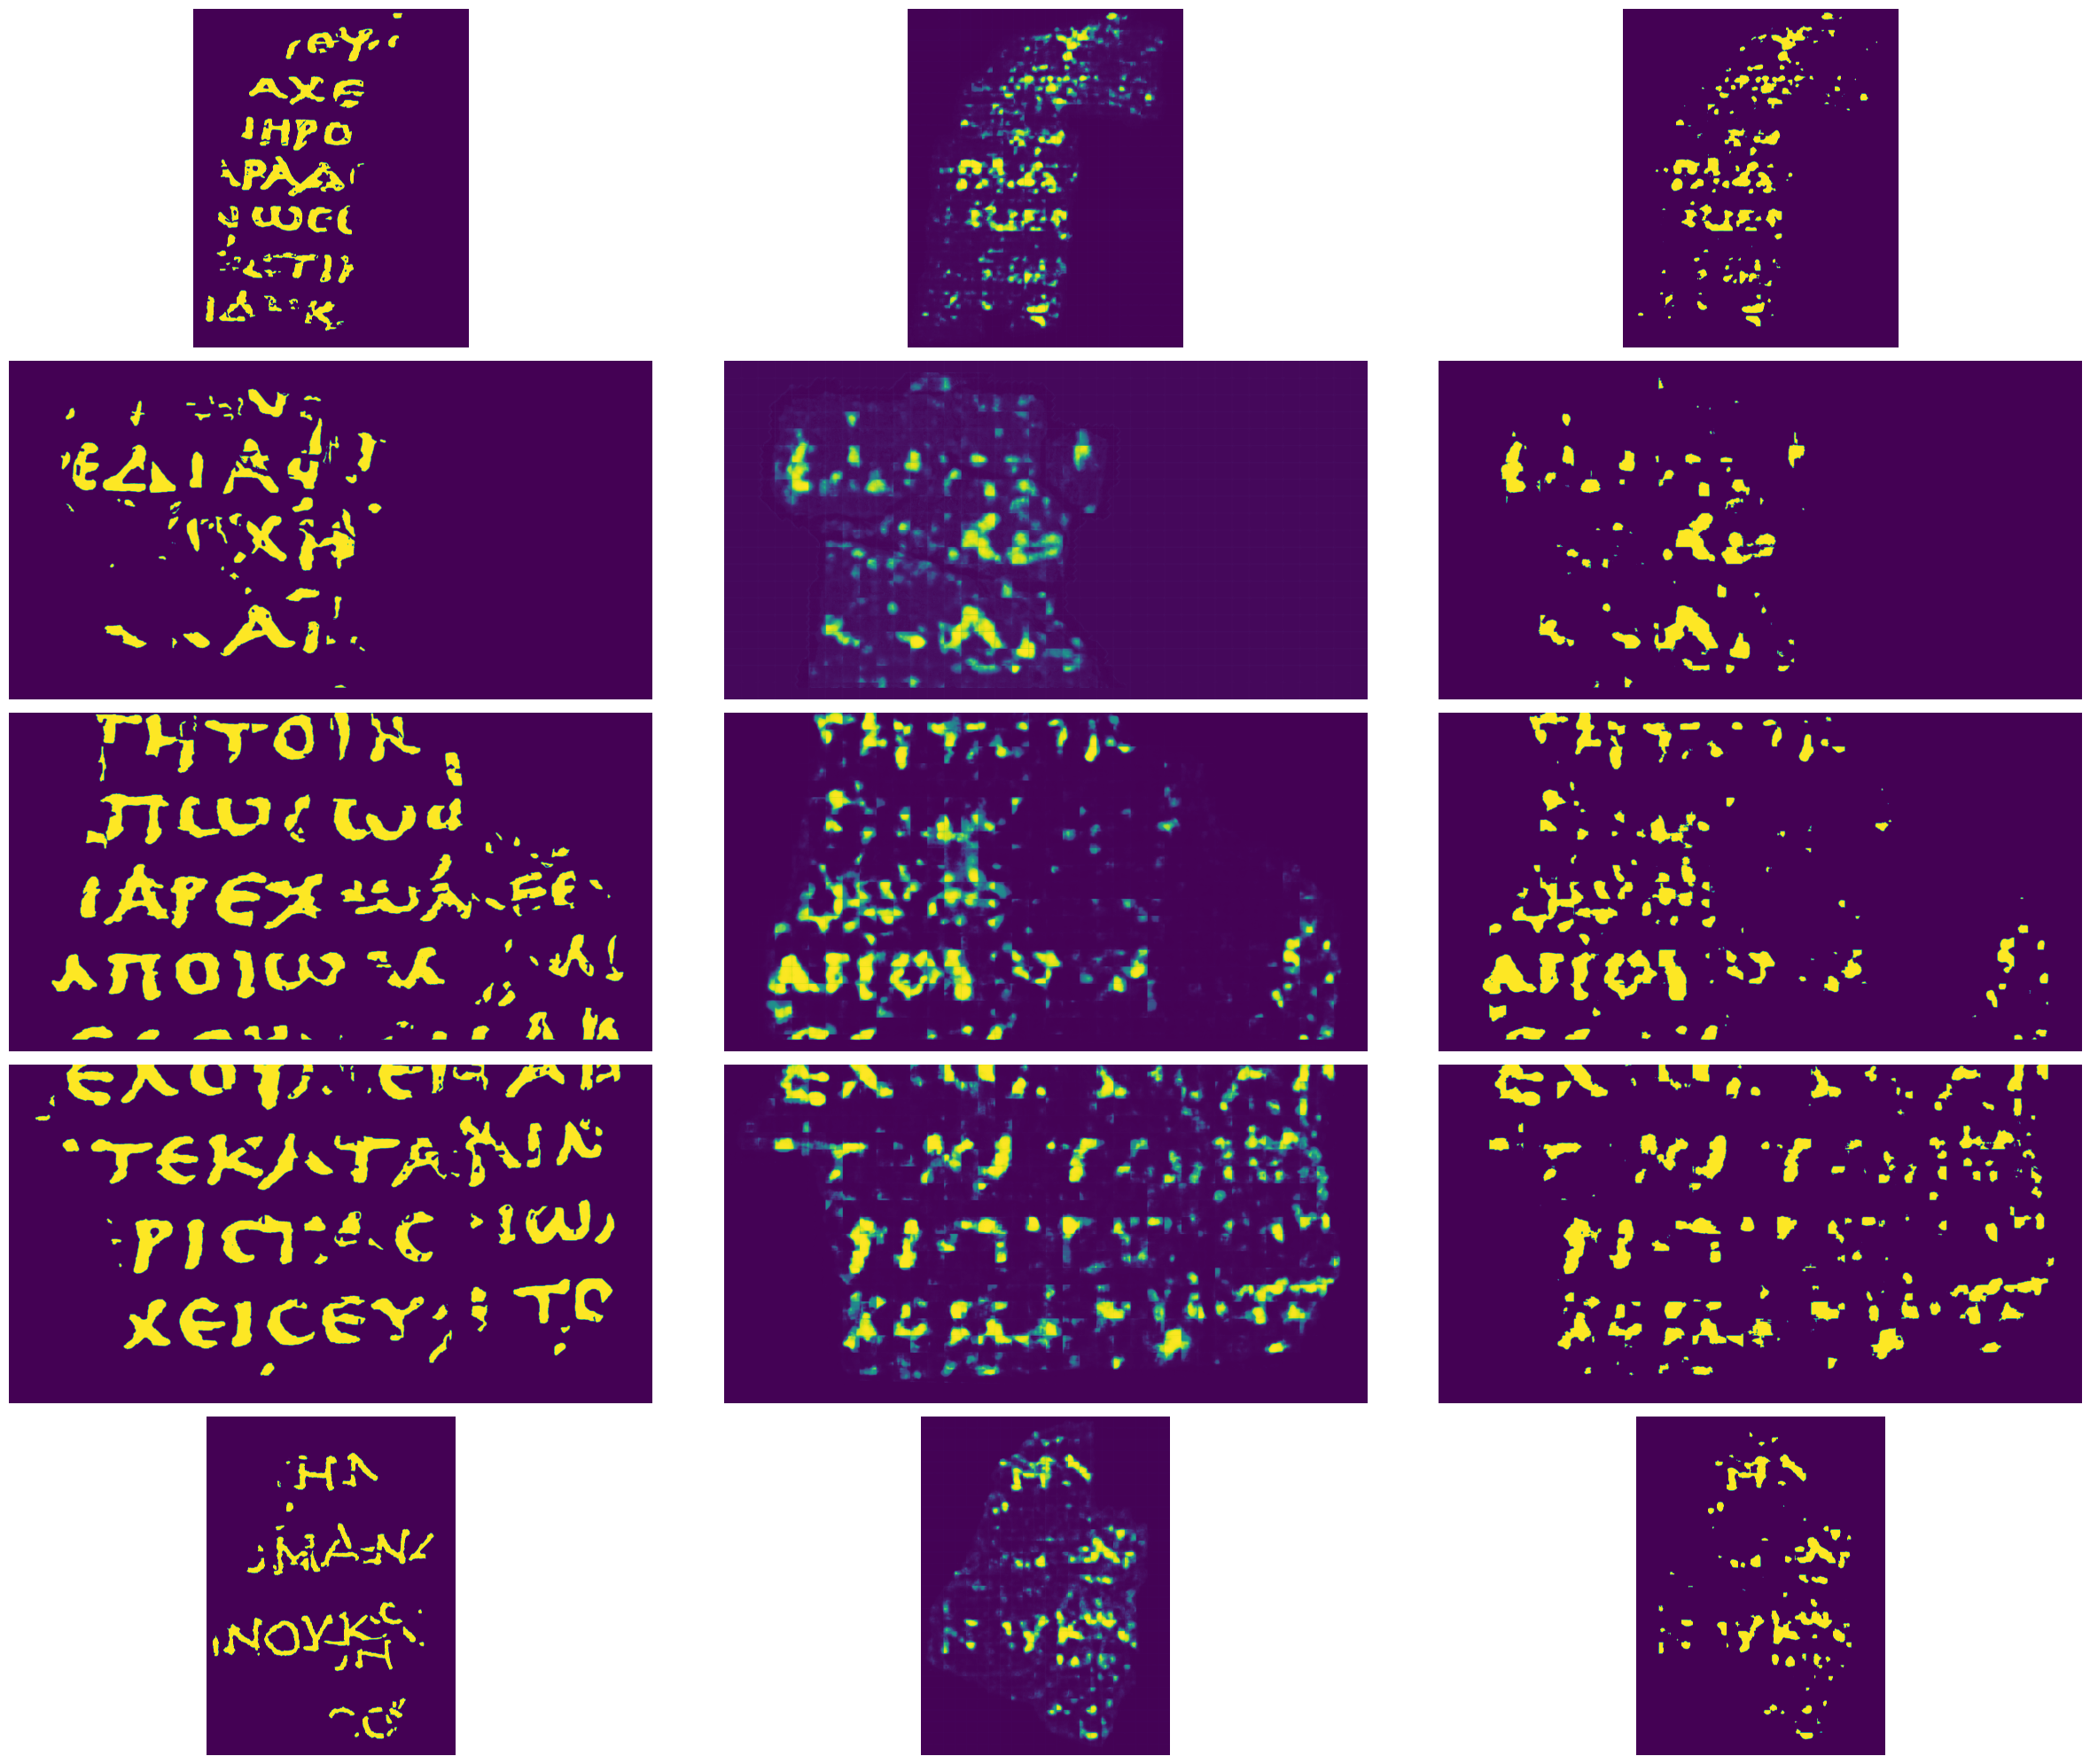

In [11]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)